In [1]:
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

In [4]:
data = pd.read_csv("../NullValueHandled/BibileMonaragalaHandledNullValues.csv", index_col=0, parse_dates=True)

In [5]:
data.head()

,Next Date,HCHO reading
Current Date,,
2019-01-01,2019-01-02,0.000019
2019-01-02,2019-01-03,0.000019
2019-01-03,2019-01-04,0.000028
2019-01-04,2019-01-05,0.000037
2019-01-05,2019-01-06,-0.000018


In [13]:
bibile_data = data[["HCHO reading"]]
bibile_data.head() 

,HCHO reading
Current Date,
2019-01-01,0.000019
2019-01-02,0.000019
2019-01-03,0.000028
2019-01-04,0.000037
2019-01-05,-0.000018


In [85]:
bibile_data.shape 

(1826, 1)

In [38]:
X = bibile_data.values 

#### This looks like that Bibile fomaldihyde rates have a seasonality

<Axes: xlabel='Current Date'>

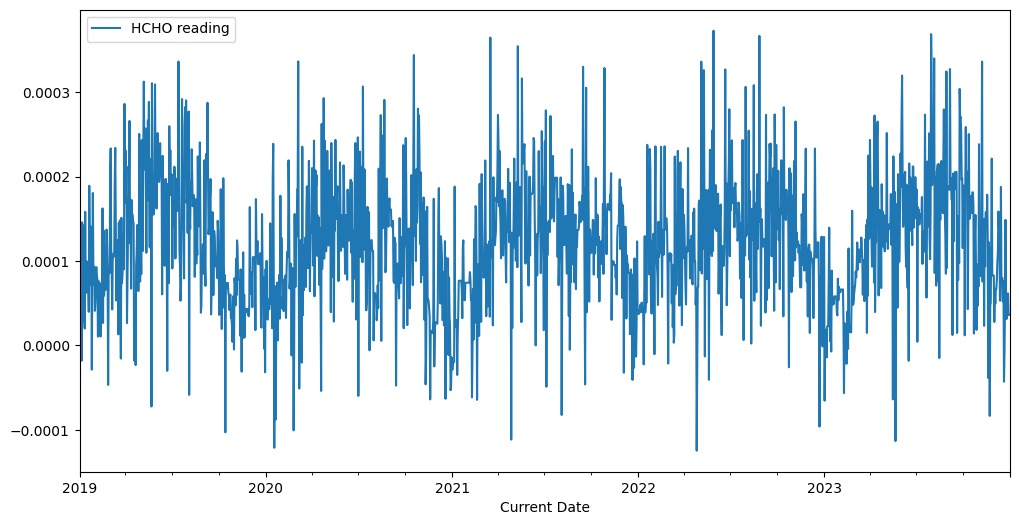

In [12]:
bibile_data.plot(figsize=(12, 6)) 

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
test_bibile = adfuller(bibile_data["HCHO reading"], autolag="AIC")

In [16]:
print("ADF value : ", test_bibile[0])
print("P value: ", test_bibile[1])
print("Num of Lags :", test_bibile[2])
print("Num of Observations used for ADF Regression and Critical Calculation :", test_bibile[3])
for key, val in test_bibile[4].items():
    print("\t", key, ": ", val)

ADF value :  -6.190170498936145
P value:  6.150214800037883e-08
Num of Lags : 11
Num of Observations used for ADF Regression and Critical Calculation : 1814
	 1% :  -3.4339600207952796
	 5% :  -2.863134623063046
	 10% :  -2.5676189242070433


#### Auto correlation and correlation plot for Bbile Monaragala

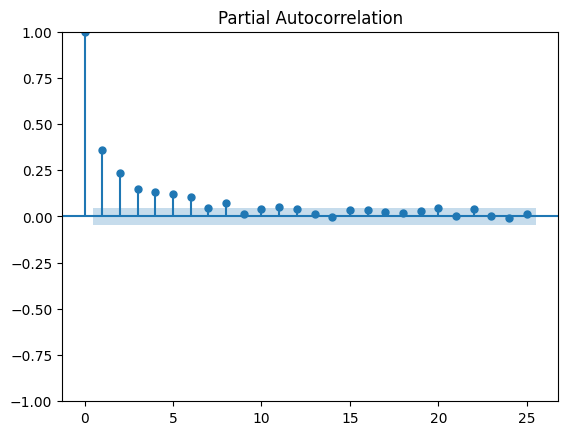

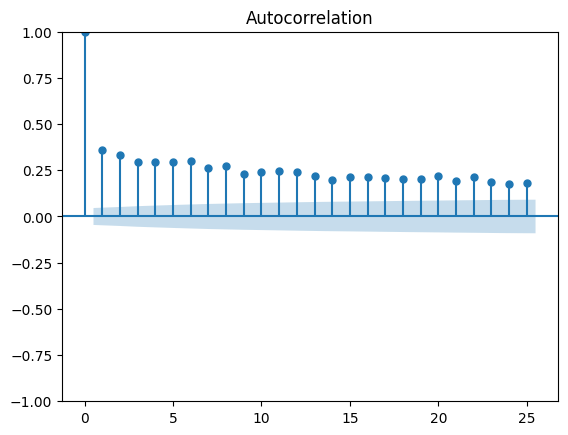

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(bibile_data["HCHO reading"], lags=25)
acf = plot_acf(bibile_data["HCHO reading"], lags=25)  

#### This auto correlation and partial correlation plots show there is a seasonality in the data

#### Bibile Monaragala LSTM

In [28]:
data = pd.read_csv("../NullValueHandled/BibileMonaragalaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [29]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000019
1   2019-01-02      0.000019
2   2019-01-03      0.000028
3   2019-01-04      0.000037
4   2019-01-05     -0.000018


In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Assuming 'data' is your DataFrame and you've loaded it successfully

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, -1])  # Assuming target is the last column
    return np.array(X), np.array(y)

sequence_length = # Adjust sequence length as necessary

# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

model = Sequential([
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=400, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True)),  # New Bidirectional LSTM layer
    Dropout(0.2),  
    Bidirectional(LSTM(units=50)),  
    Dropout(0.2),  
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])


# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/120
37/37 [==============================] - 78s 904ms/step - loss: 1.2029 - mean_squared_error: 1.2029 - val_loss: 0.9403 - val_mean_squared_error: 0.9403
Epoch 2/120
37/37 [==============================] - 14s 392ms/step - loss: 0.8927 - mean_squared_error: 0.8927 - val_loss: 0.9056 - val_mean_squared_error: 0.9056
Epoch 3/120
37/37 [==============================] - 18s 480ms/step - loss: 0.8767 - mean_squared_error: 0.8767 - val_loss: 0.9181 - val_mean_squared_error: 0.9181
Epoch 4/120
37/37 [==============================] - 16s 424ms/step - loss: 0.8441 - mean_squared_error: 0.8441 - val_loss: 1.2985 - val_mean_squared_error: 1.2985
Epoch 5/120
37/37 [==============================] - 16s 439ms/step - loss: 0.8211 - mean_squared_error: 0.8211 - val_loss: 0.9205 - val_mean_squared_error: 0.9205
Epoch 6/120
37/37 [==============================] - 23s 627ms/step - loss: 0.8102 - mean_squared_error: 0.8102 - val_loss: 1.1089 - val_mean_squared_error: 1.1089
Epoch 7/120
37/3

Epoch 51/120
37/37 [==============================] - 18s 488ms/step - loss: 0.4693 - mean_squared_error: 0.4693 - val_loss: 0.9790 - val_mean_squared_error: 0.9790
Epoch 52/120
37/37 [==============================] - 18s 473ms/step - loss: 0.3872 - mean_squared_error: 0.3872 - val_loss: 1.1812 - val_mean_squared_error: 1.1812
Epoch 53/120
37/37 [==============================] - 17s 465ms/step - loss: 0.3730 - mean_squared_error: 0.3730 - val_loss: 1.0715 - val_mean_squared_error: 1.0715
Epoch 54/120
37/37 [==============================] - 14s 387ms/step - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 1.0311 - val_mean_squared_error: 1.0311
Epoch 55/120
37/37 [==============================] - 15s 418ms/step - loss: 0.3176 - mean_squared_error: 0.3176 - val_loss: 1.2115 - val_mean_squared_error: 1.2115
Epoch 56/120
37/37 [==============================] - 16s 431ms/step - loss: 0.3010 - mean_squared_error: 0.3010 - val_loss: 1.0826 - val_mean_squared_error: 1.0826
Epoch 57/1

Epoch 101/120
37/37 [==============================] - 16s 435ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 1.0858 - val_mean_squared_error: 1.0858
Epoch 102/120
37/37 [==============================] - 17s 463ms/step - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 1.0743 - val_mean_squared_error: 1.0743
Epoch 103/120
37/37 [==============================] - 17s 471ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 1.0045 - val_mean_squared_error: 1.0045
Epoch 104/120
37/37 [==============================] - 19s 512ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - val_loss: 1.1649 - val_mean_squared_error: 1.1649
Epoch 105/120
37/37 [==============================] - 17s 473ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - val_loss: 1.1447 - val_mean_squared_error: 1.1447
Epoch 106/120
37/37 [==============================] - 16s 442ms/step - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 1.1140 - val_mean_squared_error: 1.1140
Epoc

12/12 [==============================] - 11s 120ms/step


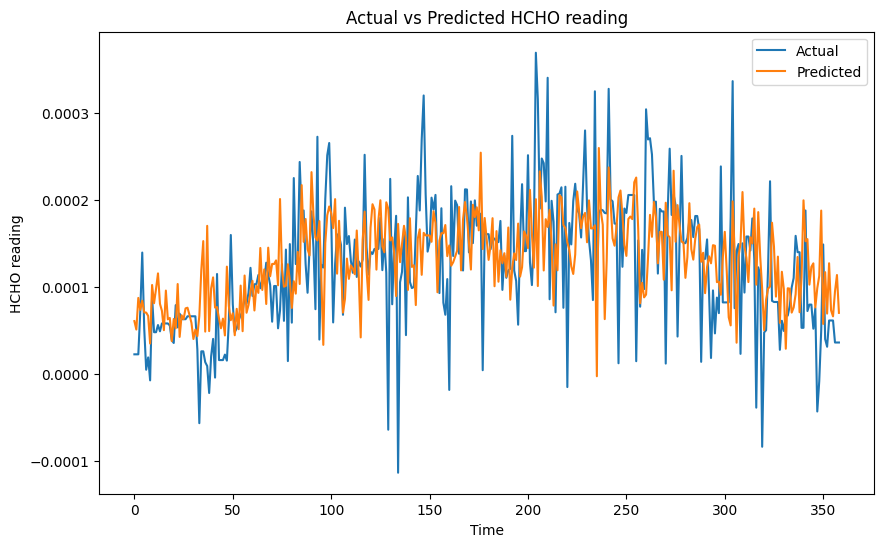

In [31]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 6s 128ms/step


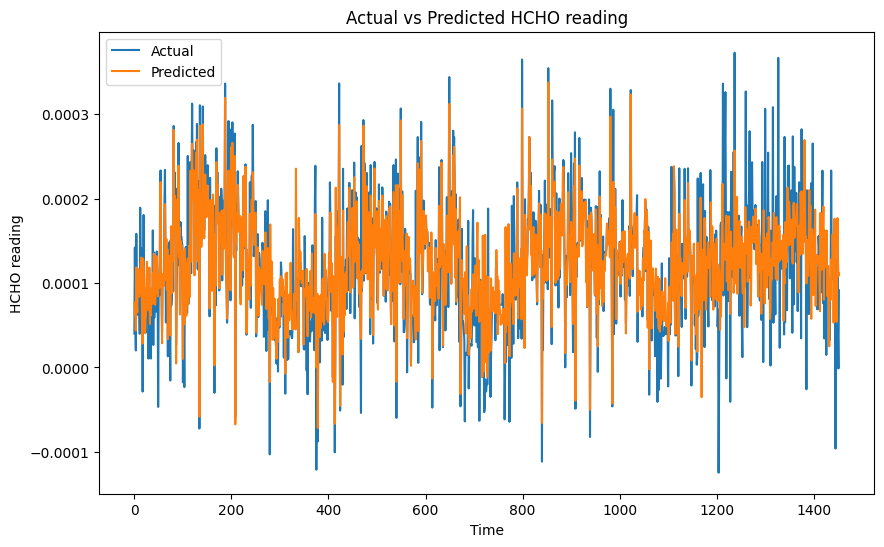

In [32]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 6s 118ms/step


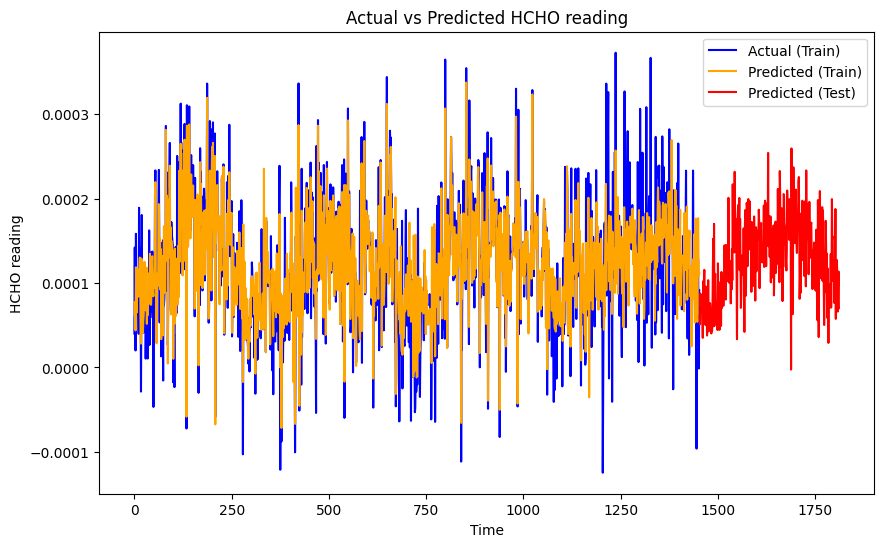

In [33]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [34]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.6388051385219051
Mean Absolute Error (MAE): 2.8173545403085707e-05
Mean Squared Error (MSE): 1.8750407967141595e-09
Root Mean Squared Error (RMSE): 4.330174126653753e-05
Median Absolute Error: 1.6345823735944656e-05
Explained Variance Score: 0.6412629438611841


21:29:04 - cmdstanpy - INFO - Chain [1] start processing
21:29:05 - cmdstanpy - INFO - Chain [1] done processing


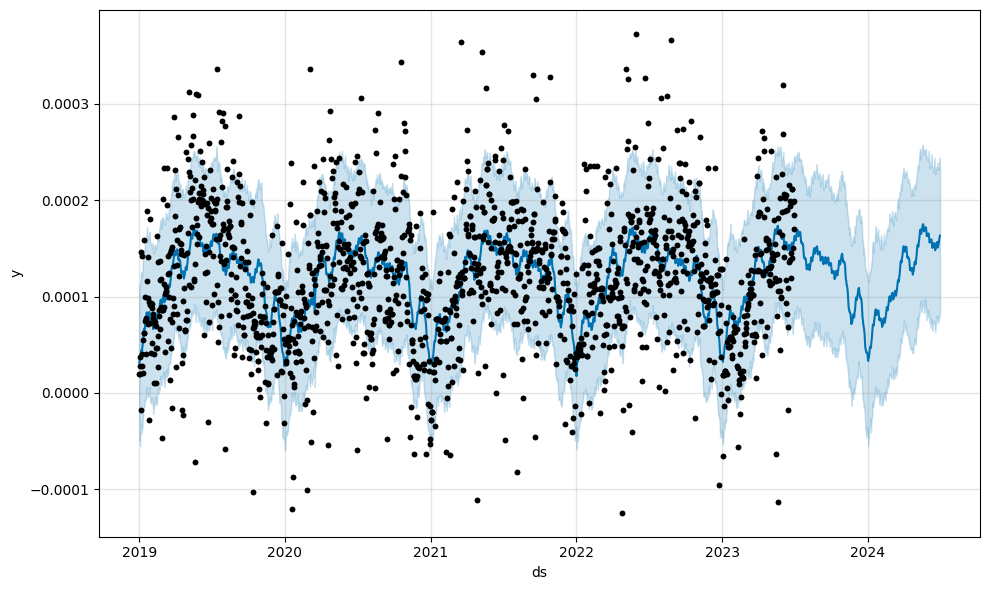

In [109]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/BibileMonaragalaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.90 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays,) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()

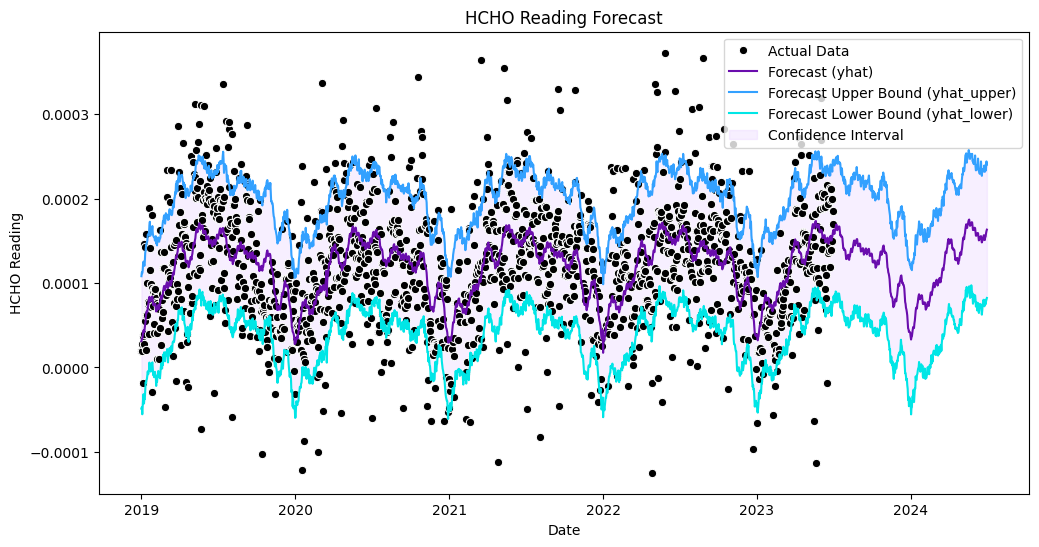

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual data
sns.lineplot(data=train_data, x='ds', y='y', label='Actual Data', color='black', marker='o', linestyle='None')

# Plot yhat - forecast
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast (yhat)', color='#6a0dad')  # Purple

# Plot yhat_upper
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Forecast Upper Bound (yhat_upper)', color='#33a1ff')  # Teal

# Plot yhat_lower
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Forecast Lower Bound (yhat_lower)', color='#00e6e6')  # Light Teal

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#d9b3ff', alpha=0.2, label='Confidence Interval')  # Light Purple

plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('HCHO Reading Forecast')

# Adjust legend
plt.legend()

plt.show()

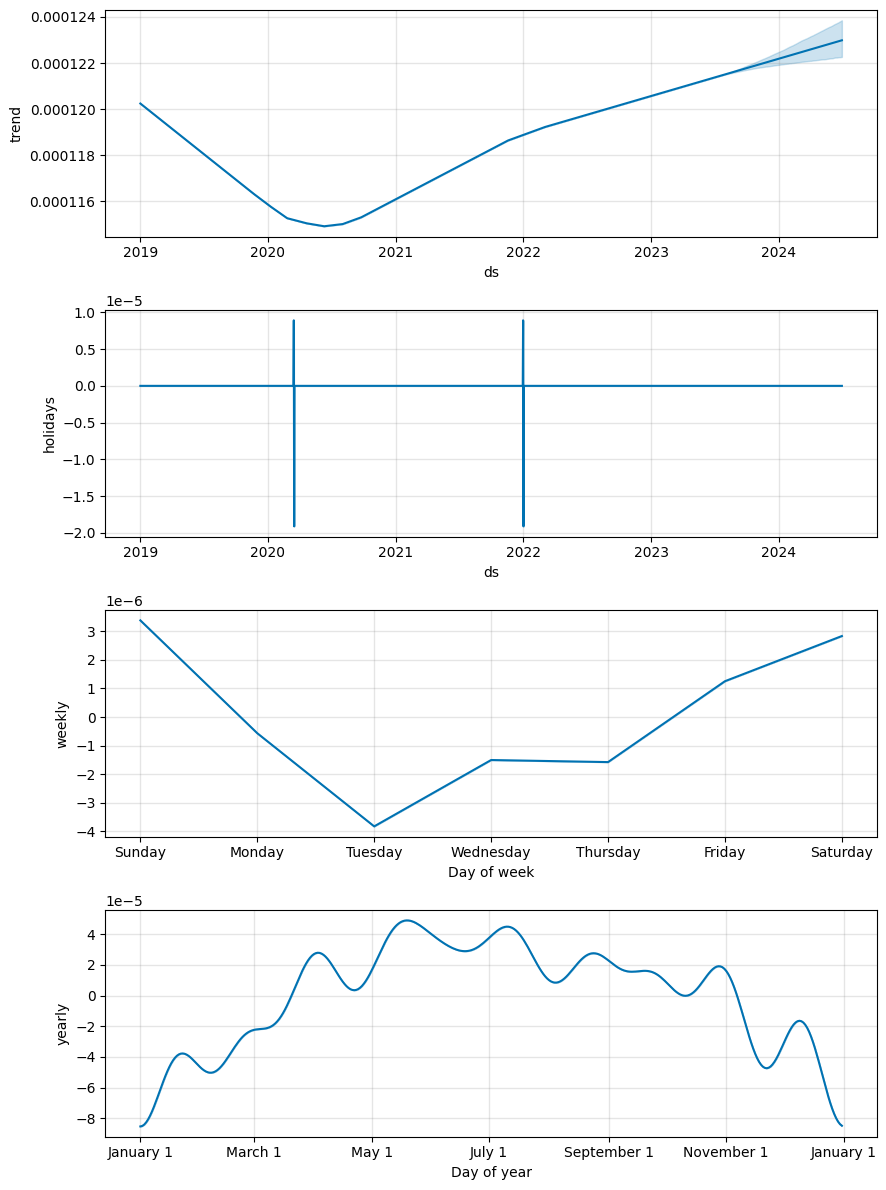

In [111]:
# Plot the forecast components
fig2 = model.plot_components(forecast)

In [112]:
y_test = test_data['y']
predicted_values = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat']  # Extract forecasted values for test period
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.13282739862940995
Mean Absolute Error (MAE): 5.667339857151609e-05
Mean Squared Error (MSE): 5.321903636499948e-09
Root Mean Squared Error (RMSE): 7.295137857847478e-05
Median Absolute Error: 4.799754309937166e-05
Explained Variance Score: 0.1775401590932143


#### Bbible Monaragala Multi Variate Model

In [16]:
from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv("../AnalysedFinalData/monaragalaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Current Date          1826 non-null   object 
 1   HCHO reading          1826 non-null   float64
 2   Region                1826 non-null   object 
 3   LATITUDE              1826 non-null   float64
 4   LONGITUDE             1826 non-null   float64
 5   ELEVATION             1826 non-null   int64  
 6   PRCP                  1826 non-null   float64
 7   TAVG                  1826 non-null   float64
 8   TMAX                  1826 non-null   float64
 9   TMIN                  1826 non-null   float64
 10  Population            1826 non-null   int64  
 11  Area_sq_km            1826 non-null   int64  
 12  population_density    1826 non-null   float64
 13  Proximity(km)         1826 non-null   float64
 14  carbon_monoxide       1826 non-null   float64
 15  nitogen_dioxide      

In [18]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [19]:
data.head()

,Current Date,HCHO reading,Region,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN,Population,Area_sq_km,population_density,Proximity(km),carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000019,"Bibile, Monaragala",7.1624,81.2216,151,0.22,71.222,79.070,65.480,40329,476,84.72,53.6,0.034253,0.000008,0.116661,0,0,Before,Before
1,2019-01-02,0.000019,"Bibile, Monaragala",7.1624,81.2216,151,0.03,69.962,78.440,63.536,40329,476,84.72,53.6,0.033293,0.000009,0.116661,0,0,Before,Before
2,2019-01-03,0.000028,"Bibile, Monaragala",7.1624,81.2216,151,0.03,69.854,79.376,62.690,40329,476,84.72,53.6,0.034194,0.000010,0.116661,0,0,Before,Before
3,2019-01-04,0.000037,"Bibile, Monaragala",7.1624,81.2216,151,0.02,69.584,79.628,62.186,40329,476,84.72,53.6,0.032600,0.000008,0.116661,0,0,Before,Before
4,2019-01-05,-0.000018,"Bibile, Monaragala",7.1624,81.2216,151,0.14,71.816,81.356,64.076,40329,476,84.72,53.6,0.034562,0.000010,0.116661,0,0,Before,Before


#### remove constant data

In [20]:
data.columns

Index(['Current Date', 'HCHO reading', 'Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'Population', 'Area_sq_km',
       'population_density', 'Proximity(km)', 'carbon_monoxide',
       'nitogen_dioxide', 'ozone', 'new_covid_patients',
       'total_covid_patients', 'lockdown_status', 'covid_range_status'],
      dtype='object')

In [21]:
data.drop(columns=['Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION','Area_sq_km', 'Proximity(km)', 'Population', 'population_density'], inplace=True)

In [22]:
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000019,0.22,71.222,79.070,65.480,0.034253,0.000008,0.116661,0,0,Before,Before
1,2019-01-02,0.000019,0.03,69.962,78.440,63.536,0.033293,0.000009,0.116661,0,0,Before,Before
2,2019-01-03,0.000028,0.03,69.854,79.376,62.690,0.034194,0.000010,0.116661,0,0,Before,Before
3,2019-01-04,0.000037,0.02,69.584,79.628,62.186,0.032600,0.000008,0.116661,0,0,Before,Before
4,2019-01-05,-0.000018,0.14,71.816,81.356,64.076,0.034562,0.000010,0.116661,0,0,Before,Before


#### Encode Categorical data

In [23]:
from sklearn.preprocessing import LabelEncoder
 
dates = data["Current Date"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in the DataFrame
for column in data.columns:
    # Check if the column is of categorical type
    if data[column].dtype == 'object':
        # Fit label encoder and transform values
        data[column] = label_encoder.fit_transform(data[column])

In [24]:
data["Current Date"] = dates
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000019,0.22,71.222,79.070,65.480,0.034253,0.000008,0.116661,0,0,1,1
1,2019-01-02,0.000019,0.03,69.962,78.440,63.536,0.033293,0.000009,0.116661,0,0,1,1
2,2019-01-03,0.000028,0.03,69.854,79.376,62.690,0.034194,0.000010,0.116661,0,0,1,1
3,2019-01-04,0.000037,0.02,69.584,79.628,62.186,0.032600,0.000008,0.116661,0,0,1,1
4,2019-01-05,-0.000018,0.14,71.816,81.356,64.076,0.034562,0.000010,0.116661,0,0,1,1


#### Check correlations

In [25]:
corr = data.corr(numeric_only=True)["HCHO reading"]
corr = pd.DataFrame(corr)
corr

,HCHO reading
HCHO reading,1.000000
PRCP,-0.045412
TAVG,0.374357
TMAX,0.357828
TMIN,0.275180
carbon_monoxide,-0.301561
nitogen_dioxide,0.171317
ozone,0.414593
new_covid_patients,0.037962
total_covid_patients,0.070916


In [26]:
corr.to_csv("../OtherData/MonaragalaCorrelationData.csv")

In [27]:
data.shape

(1826, 13)

#### remove covid lockdown status

In [28]:
data.drop(columns=["lockdown_status"], inplace=True)

#### Devide X and Y

In [29]:
X = data.drop(columns=["HCHO reading"])
y = data["HCHO reading"]

In [30]:
X.head()

,Current Date,PRCP,TAVG,TMAX,TMIN,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,covid_range_status
0,2019-01-01,0.22,71.222,79.070,65.480,0.034253,0.000008,0.116661,0,0,1
1,2019-01-02,0.03,69.962,78.440,63.536,0.033293,0.000009,0.116661,0,0,1
2,2019-01-03,0.03,69.854,79.376,62.690,0.034194,0.000010,0.116661,0,0,1
3,2019-01-04,0.02,69.584,79.628,62.186,0.032600,0.000008,0.116661,0,0,1
4,2019-01-05,0.14,71.816,81.356,64.076,0.034562,0.000010,0.116661,0,0,1


#### Select features based on Correlations

In [31]:
data.corr(numeric_only=True)["HCHO reading"]

HCHO reading            1.000000
PRCP                   -0.045412
TAVG                    0.374357
TMAX                    0.357828
TMIN                    0.275180
carbon_monoxide        -0.301561
nitogen_dioxide         0.171317
ozone                   0.414593
new_covid_patients      0.037962
total_covid_patients    0.070916
covid_range_status     -0.049795
Name: HCHO reading, dtype: float64

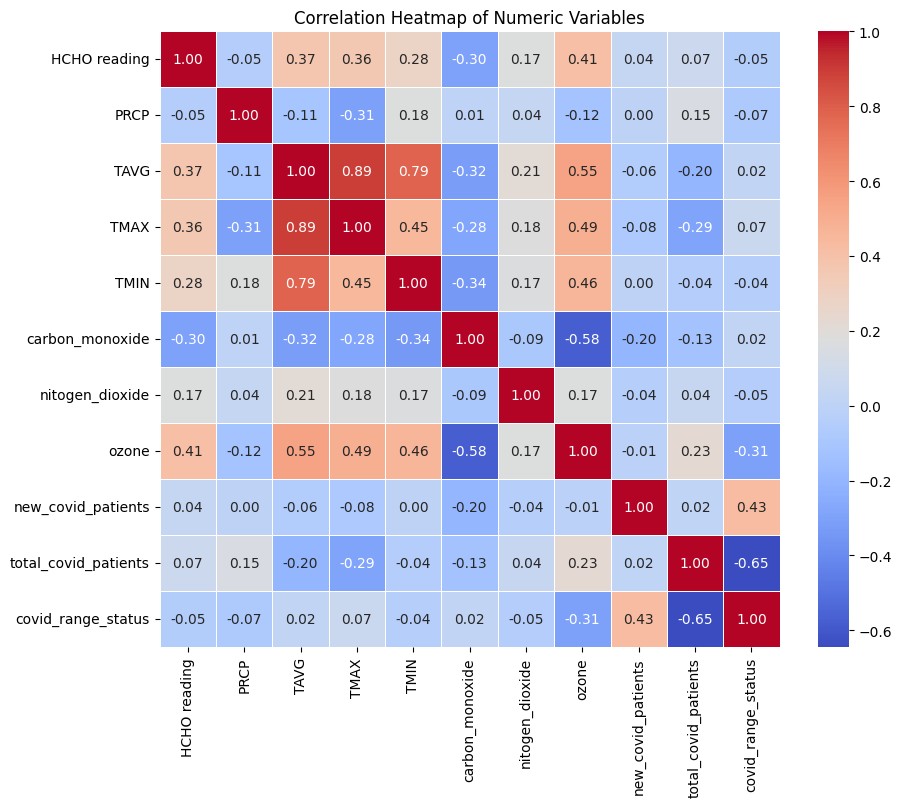

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data is your DataFrame
correlation_matrix = data.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

In [33]:
X = X[["Current Date", "carbon_monoxide", "ozone", "TAVG"]]
X.head() 

,Current Date,carbon_monoxide,ozone,TAVG
0,2019-01-01,0.034253,0.116661,71.222
1,2019-01-02,0.033293,0.116661,69.962
2,2019-01-03,0.034194,0.116661,69.854
3,2019-01-04,0.032600,0.116661,69.584
4,2019-01-05,0.034562,0.116661,71.816


In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Current Date     1826 non-null   object 
 1   carbon_monoxide  1826 non-null   float64
 2   ozone            1826 non-null   float64
 3   TAVG             1826 non-null   float64
dtypes: float64(3), object(1)
memory usage: 57.2+ KB


#### Standardize, variable data

In [73]:
from sklearn.preprocessing import StandardScaler
# Select columns of interest
selected_columns = ["carbon_monoxide", "ozone", "TAVG"]

# Convert "Current Date" to datetime format
data["Current Date"] = pd.to_datetime(data["Current Date"])

# Separate the "Current Date" column
current_date = data["Current Date"]

# Select only the columns you're interested in for standardization
X = X[selected_columns]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the data
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_columns)

# Concatenate "Current Date" column with the scaled data
X = pd.concat([current_date, X_scaled_df], axis=1)

X.set_index("Current Date", inplace=True)

In [74]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carbon_monoxide  1826 non-null   float64
 1   ozone            1826 non-null   float64
 2   TAVG             1826 non-null   float64
dtypes: float64(3)
memory usage: 57.1 KB


##### Standardize target variable

In [75]:
y = data['HCHO reading']

y.head()

0    0.000019
1    0.000019
2    0.000028
3    0.000037
4   -0.000018
Name: HCHO reading, dtype: float64

In [104]:
from sklearn.preprocessing import MinMaxScaler
scaler_y = MinMaxScaler()
y_scaled = np.array(scaler_y.fit_transform(y.values.reshape(-1, 1)), ndmin=1)

In [105]:
y_scaled[:5]

array([[0.28918411],
       [0.28918411],
       [0.30710946],
       [0.32593993],
       [0.21442571]])

In [106]:
X_scaled = X 

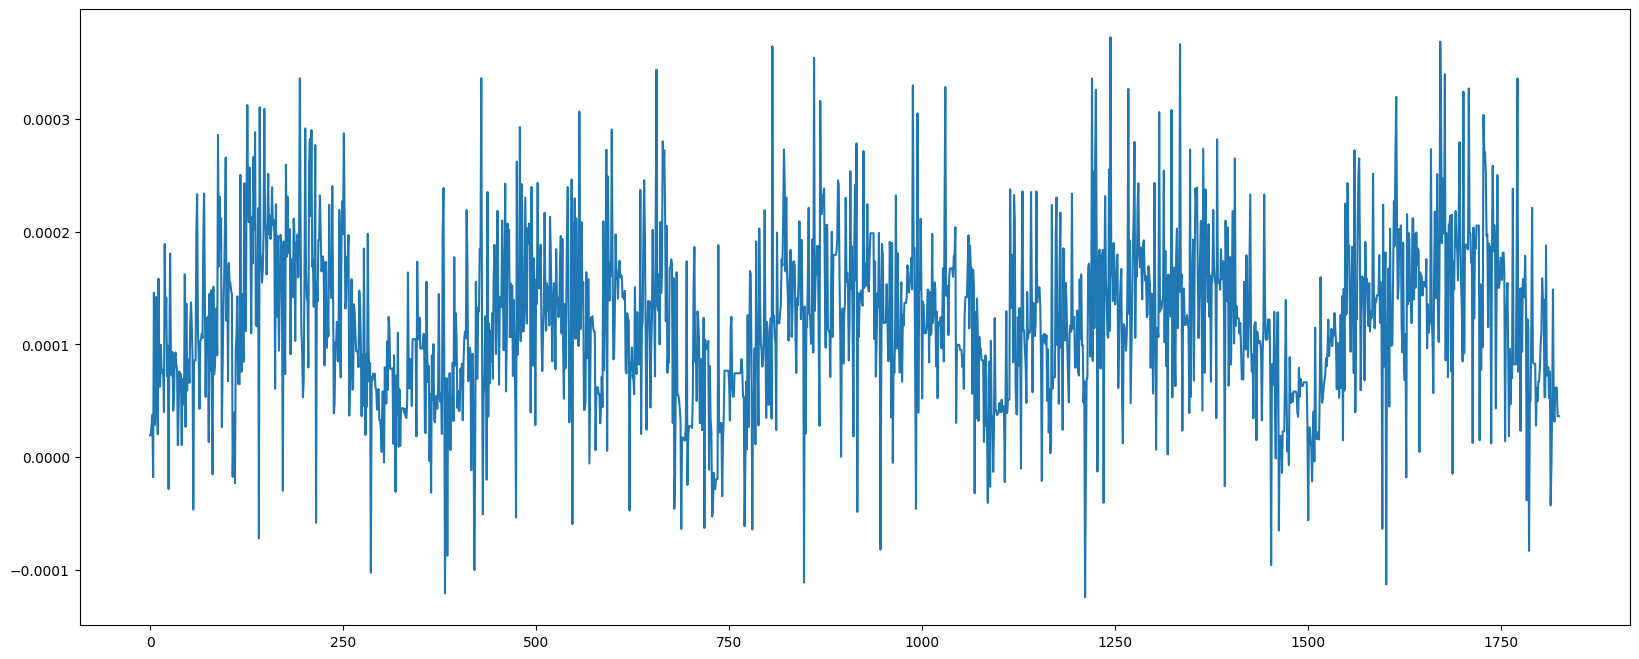

In [107]:
plt.figure(figsize=(20, 8))
plt.plot(scaler_y.inverse_transform(y_scaled))

#### Apply multivariate time series model

In [315]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanAbsoluteError


# Now, split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X_scaled) * split_ratio)

X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))


model = Sequential([
    Bidirectional(LSTM(units=120, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.5), # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=5, activation="tanh")),  # New Bidirectional LSTM layer
    Dropout(0.5),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

# Compilation of the model
optimizer = Adam(learning_rate=0.007)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/100
12/12 [==============================] - 14s 224ms/step - loss: 0.1404 - mse: 0.1404 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 2/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0483 - mse: 0.0483 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 3/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 4/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0206 - val_mse: 0.0206
Epoch 5/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 6/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 7/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 8/100
12/12 [==============================] - 0s 13ms/step - loss: 

12/12 [==============================] - 0s 3ms/step - loss: 0.0187 - mse: 0.0187
Test Loss: [0.018710097298026085, 0.018710097298026085]
12/12 [==============================] - 2s 3ms/step


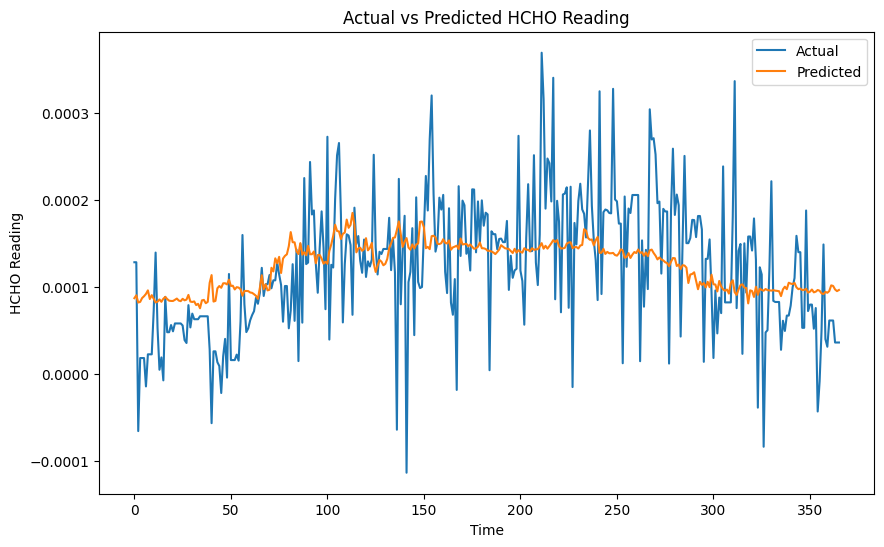

In [316]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)

# Optionally, you can inverse transform the predictions to get them back to the original scale
predictions_inv = scaler_y.inverse_transform(predictions)
actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO Reading')
plt.title('Actual vs Predicted HCHO Reading')
plt.legend()
plt.show()

46/46 [==============================] - 0s 3ms/step


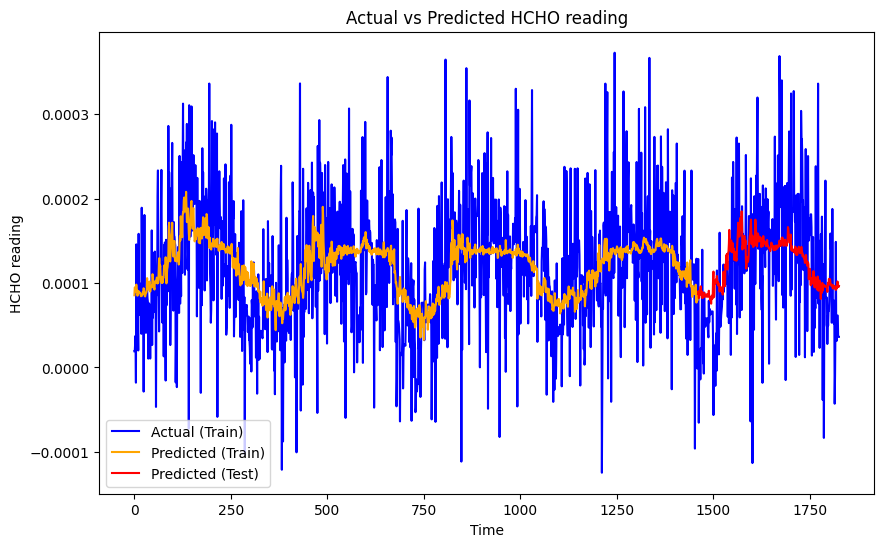

In [317]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler_y.inverse_transform(predictions)
actual_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler_y.inverse_transform(predictions_scaled_train)
actual_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(data["HCHO reading"], label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [318]:
r2 = r2_score(actual_test, predictions_test)
mae = mean_absolute_error(actual_test, predictions_test)
mse = mean_squared_error(actual_test, predictions_test)
rmse = mean_squared_error(actual_test, predictions_test, squared=False)
median_absolute = median_absolute_error(actual_test,predictions_test)
explained_variance = explained_variance_score(actual_test, predictions_test)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.21960766688568234
Mean Absolute Error (MAE): 5.209012947869187e-05
Mean Squared Error (MSE): 4.6282401282068256e-09
Root Mean Squared Error (RMSE): 6.803117026927309e-05
Median Absolute Error: 4.258480277239577e-05
Explained Variance Score: 0.21973129097185107


#### Single Variate Time Series Models

#### AR Model

In [34]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/monaragalaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TAVG': data["TAVG"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"] 
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')


# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ARIMA example
yhat_ar = [] 

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = ARIMA(temp_train, order=(1, 0, 0))  # AR model with p=1, d=0, q=0 (since it's AR)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)[0]  # Forecasting 1 step ahead
    yhat_ar.append(predictions)

yhat_ar = pd.Series(yhat_ar, index=test.index)
ar_mse = mean_squared_error(test['HCHO reading'], yhat_ar)

# Print or store the results
print("ARIMA MSE:", ar_mse)


100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [02:09<00:00,  2.82it/s]

ARIMA MSE: 4.897541749590813e-09


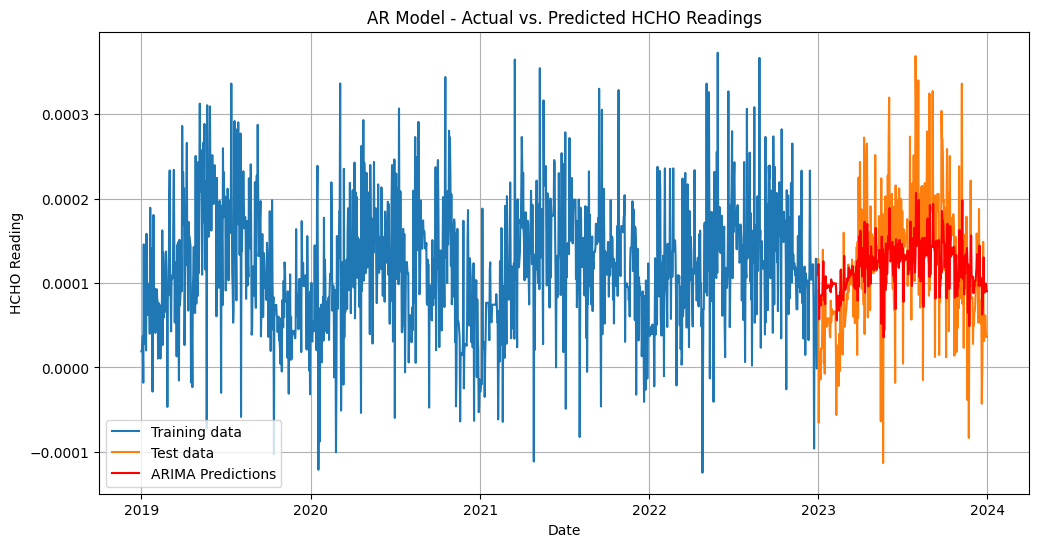

In [35]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_ar, label='ARIMA Predictions', color='red')
plt.title('AR Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

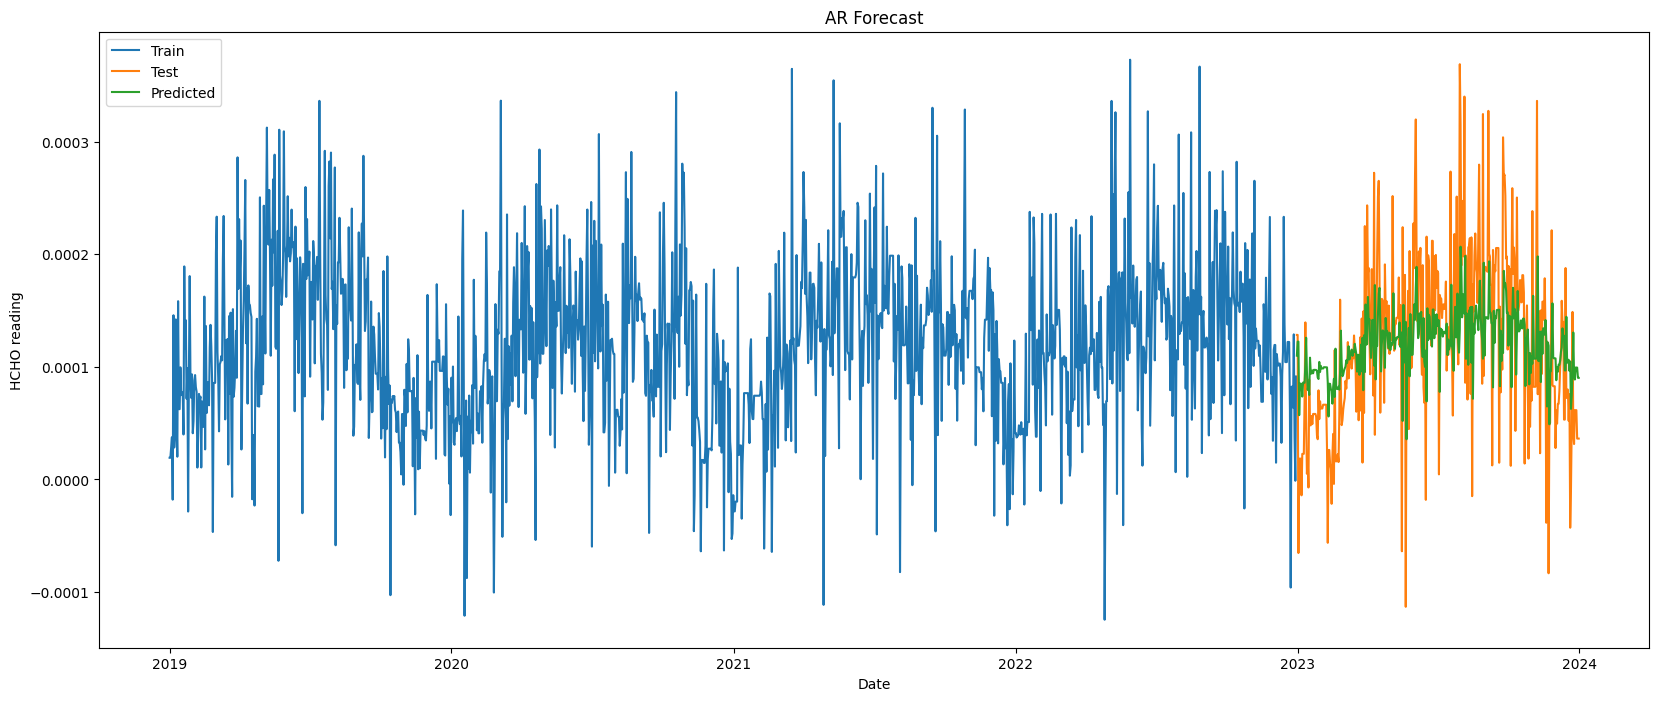

In [36]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(20, 8))
plt.plot(train.index, train['HCHO reading'], label='Train')
plt.plot(test.index, test['HCHO reading'], label='Test')
plt.plot(test.index, yhat_ar, label='Predicted')

plt.title('AR Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO reading')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_ar)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_ar)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_ar) 

rmse = mean_squared_error(test['HCHO reading'], yhat_ar, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_ar)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_ar) 


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 5.4030355360961946e-05
Mean Squared Error (MSE): 4.897541749590813e-09
R-squared (R2) Score: 0.17419927950696956
Root Mean Squared Error (RMSE): 6.998243886569554e-05
Median Absolute Error: 4.16256862840991e-05
Explained Variance Score: 0.1755427364113562


#### Single-variate ARMA model

In [29]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/monaragalaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TAVG': data["TAVG"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ARIMA example
yhat_arma = []

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = ARIMA(temp_train, order=(5, 0, 0))  # ARMA model with p=1,d=0,  q=1
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=365)[0]
    yhat_arma.append(predictions)

yhat_arma = pd.Series(yhat_arma, index=test.index)
arma_mse = mean_squared_error(test['HCHO reading'], yhat_arma)

# Print or store the results
print("ARIMA MSE:", arma_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [11:16<00:00,  1.85s/it]

ARIMA MSE: 4.168152559429299e-09


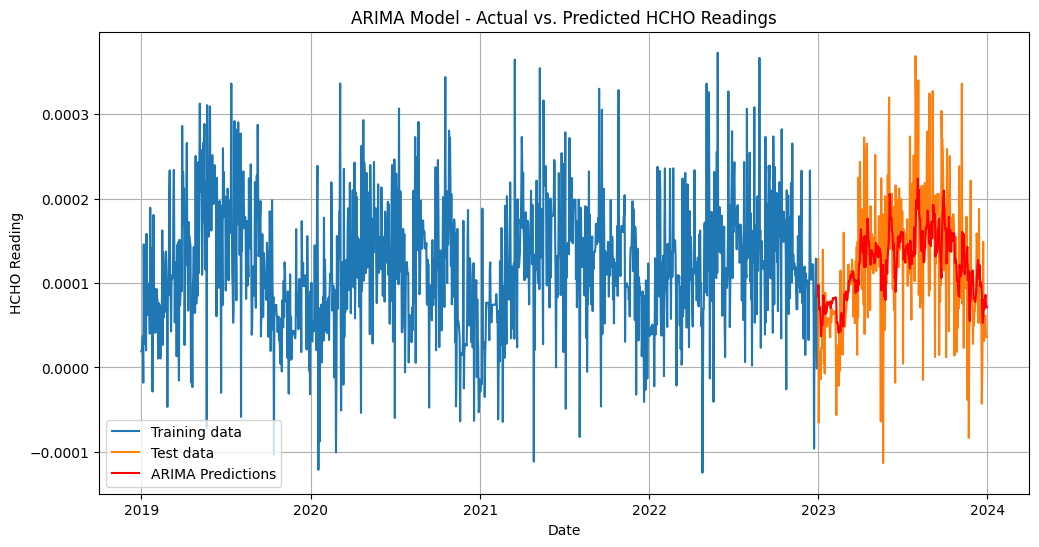

In [30]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_arma, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

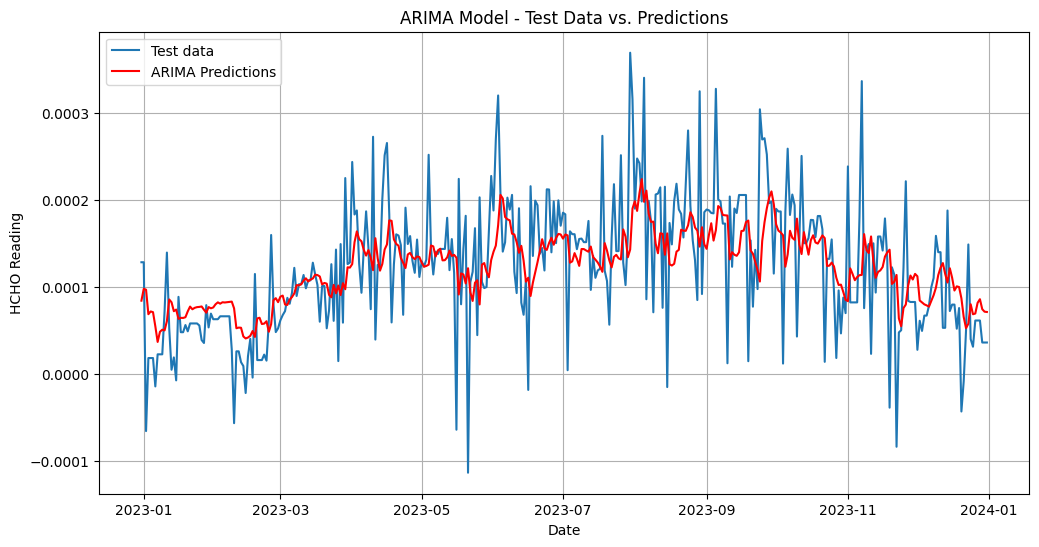

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_arma, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Test Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_arma)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_arma)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_arma)

rmse = mean_squared_error(test['HCHO reading'], yhat_arma, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_arma)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_arma)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.571041704345771e-05
Mean Squared Error (MSE): 4.168152559429299e-09
R-squared (R2) Score: 0.2971854937246494
Root Mean Squared Error (RMSE): 6.456123108669242e-05
Median Absolute Error: 3.0423461658134894e-05
Explained Variance Score: 0.29742495638625965


#### SARIMA model technique(2)

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/monaragalaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TAVG': data["TAVG"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# SARIMA example using auto_arima
model = auto_arima(train['HCHO reading'], exogenous=train[['carbon_monoxide', 'TAVG', 'ozone']],
                   seasonal=True, m=12,  # assuming monthly seasonality
                   trace=True)  # to display the model selection process
model_fit = model.fit(train['HCHO reading'], exogenous=train[['carbon_monoxide', 'TAVG', 'ozone']])

# Forecasting
forecast = model_fit.predict(n_periods=len(test), exogenous=test[['carbon_monoxide', 'TAVG', 'ozone']])

# Calculating MSE
sarima_mse = mean_squared_error(test['HCHO reading'], forecast)

# Print or store the results
print("SARIMA MSE:", sarima_mse)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-22908.363, Time=5.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-23698.945, Time=0.55 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-23327.595, Time=6.51 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-23802.206, Time=9.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-21778.077, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-23760.488, Time=1.53 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-23577.924, Time=13.43 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-23802.053, Time=26.80 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-23355.189, Time=4.28 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=47.21 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-23746.319, Time=6.97 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-23943.167, Time=9.36 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-23925.667, Time=2.12 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-23875.770, Time=9.76

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/monaragalaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TAVG': data["TAVG"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# SARIMA example
yhat_sarima = []

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = SARIMAX(temp_train, order=(5, 0, 0), seasonal_order=(0, 0, 0, 12)) 
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)  # Forecasting 10 steps ahead
    yhat_sarima.append(predictions[-1])  # Appending only the last value of the forecast

yhat_sarima = pd.Series(yhat_sarima, index=test.index)
sarima_mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Print or store the results
print("SARIMA MSE:", sarima_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [06:54<00:00,  1.13s/it]

SARIMA MSE: 4.293696889332938e-09


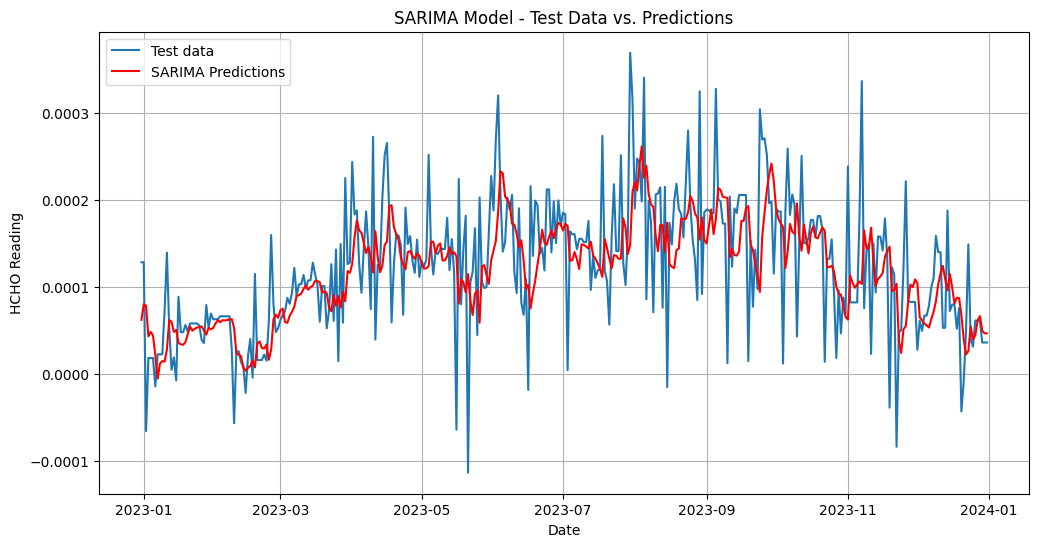

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_sarima, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Test Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

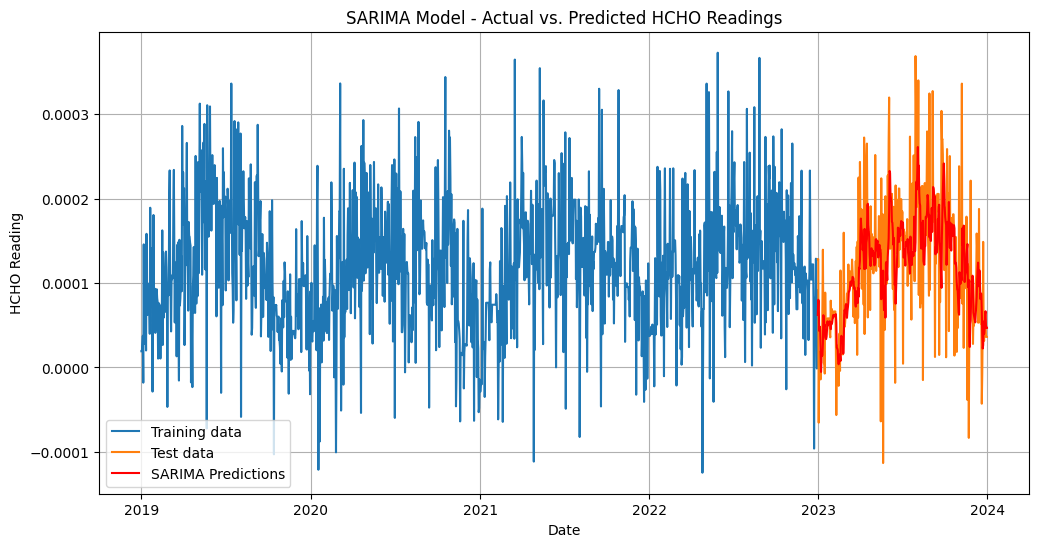

In [16]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_sarima, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True) 
plt.show()

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_sarima)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_sarima)

rmse = mean_squared_error(test['HCHO reading'], yhat_sarima, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_sarima)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_sarima)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.461504932419022e-05
Mean Squared Error (MSE): 4.293696889332938e-09
R-squared (R2) Score: 0.2760167924885851
Root Mean Squared Error (RMSE): 6.552630684948555e-05
Median Absolute Error: 2.606433583349303e-05
Explained Variance Score: 0.2811049096781292


#### Multi Variate Models

#### BayesianRidge Model

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv("../AnalysedFinalData/monaragalaData.csv", parse_dates=True)

# Drop the "Next Date" column
data.drop(columns=["Next Date"], inplace=True)

# Prepare the data
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TAVG': data["TAVG"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}

data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Extracting features and target variable
X_train = train[['TAVG', 'ozone', 'carbon_monoxide']].values
y_train = train['HCHO reading'].values
X_test = test[['TAVG', 'ozone', 'carbon_monoxide']].values
y_test = test['HCHO reading'].values

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Bayesian Regression
bayesian_reg = BayesianRidge()

# Fit the model
bayesian_reg.fit(X_train_scaled, y_train_scaled)

# Predictions
y_train_pred = bayesian_reg.predict(X_train_scaled)
y_test_pred = bayesian_reg.predict(X_test_scaled)

# Inverse transform to get actual values
y_train_pred_actual = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_test_pred_actual = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_actual))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_actual))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 6.502656031107638e-05
Test RMSE: 6.640596776882187e-05


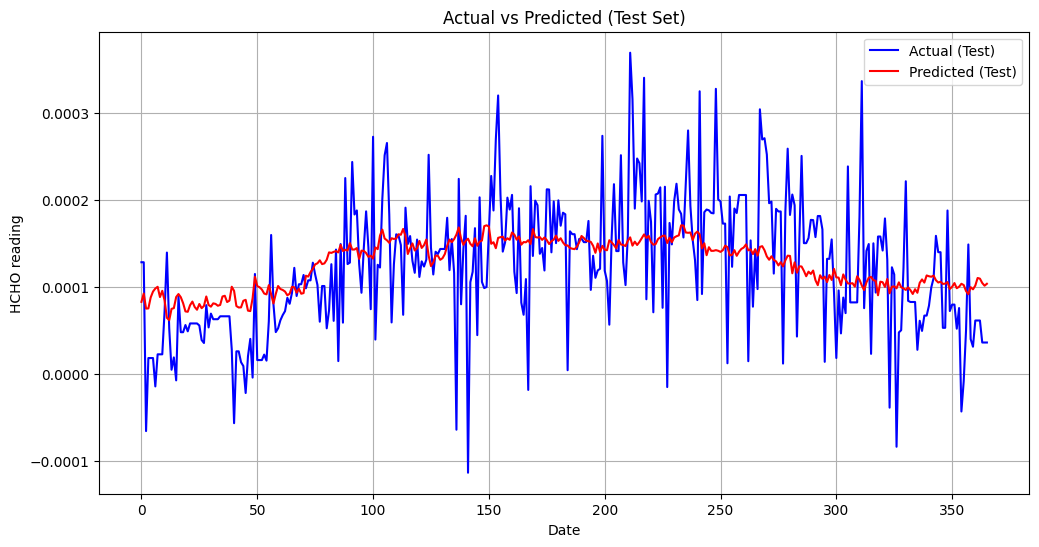

In [20]:
# Plot actual vs predicted for test set
plt.figure(figsize=(12, 6))
plt.plot([x for x in range(0, len(y_test))], y_test, label='Actual (Test)', color='blue')
plt.plot([x for x in range(0, len(y_test))], y_test_pred_actual, label='Predicted (Test)', color='red')
plt.title('Actual vs Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('HCHO reading') 
plt.legend()
plt.grid(True)
plt.show()

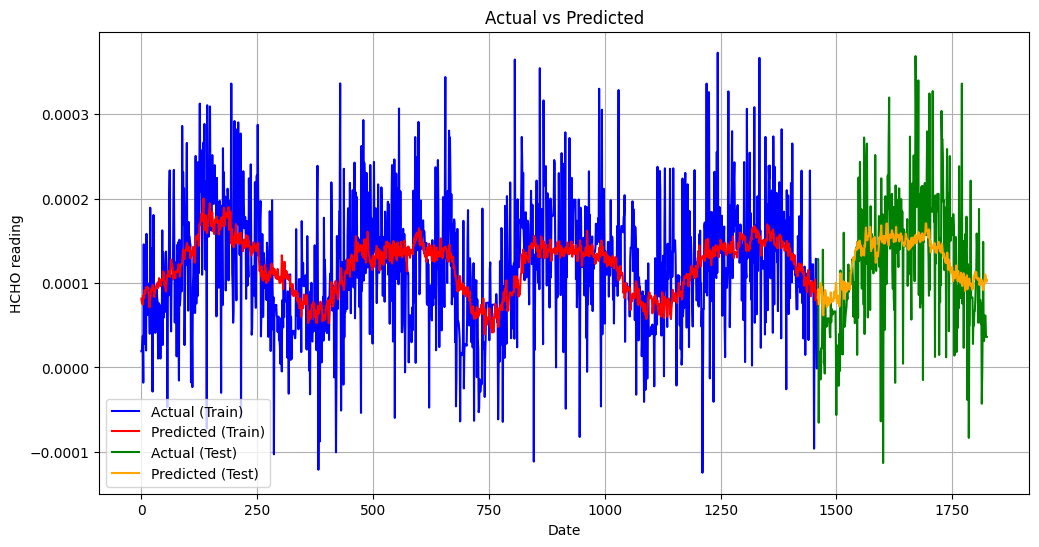

In [21]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for both training and test sets
plt.figure(figsize=(12, 6)) 
plt.plot(range(0, len(y_train)), y_train, label='Actual (Train)', color='blue')
plt.plot(range(0, len(y_train)), y_train_pred_actual, label='Predicted (Train)', color='red')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual (Test)', color='green')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test_pred_actual, label='Predicted (Test)', color='orange')
plt.title('Actual vs Predicted')
plt.xlabel('Date') 
plt.ylabel('HCHO reading')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred_actual)

# Calculate MSE
mse = mean_squared_error(y_test, y_test_pred_actual)

# Calculate R2 score 
r2 = r2_score(y_test, y_test_pred_actual)

rmse = mean_squared_error(y_test, y_test_pred_actual, squared=False)

median_absolute = median_absolute_error(y_test, y_test_pred_actual) 
 
explained_variance = explained_variance_score(y_test, y_test_pred_actual)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 5.064143240521853e-05
Mean Squared Error (MSE): 4.409752555313809e-09
R-squared (R2) Score: 0.2564480256491173
Root Mean Squared Error (RMSE): 6.640596776882187e-05
Median Absolute Error: 4.163199015847961e-05
Explained Variance Score: 0.2578265211137366


#### Random Forest Model

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Load the data
data = pd.read_csv("../AnalysedFinalData/monaragalaData.csv", parse_dates=True)

# Drop the "Next Date" column
data.drop(columns=["Next Date"], inplace=True)

# Prepare the data
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TAVG': data["TAVG"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}

data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Extracting features and target variable
X_train = train[['TAVG', 'carbon_monoxide', 'ozone']].values
y_train = train['HCHO reading'].values
X_test = test[['TAVG', 'carbon_monoxide', 'ozone']].values
y_test = test['HCHO reading'].values

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Define the Random Forest model
random_forest_reg = RandomForestRegressor()

# Define the hyperparameters to search
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(random_forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train_scaled)

# Get the best model
best_random_forest_reg = grid_search.best_estimator_

In [25]:
# Predictions
y_train_pred = best_random_forest_reg.predict(X_train_scaled)
y_test_pred = best_random_forest_reg.predict(X_test_scaled)

# Inverse transform to get actual values
y_train_pred_actual = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_test_pred_actual = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_actual))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_actual))

print("Best Parameters:", grid_search.best_params_)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 20}
Train RMSE: 5.0882973082746174e-05
Test RMSE: 7.101866642137954e-05


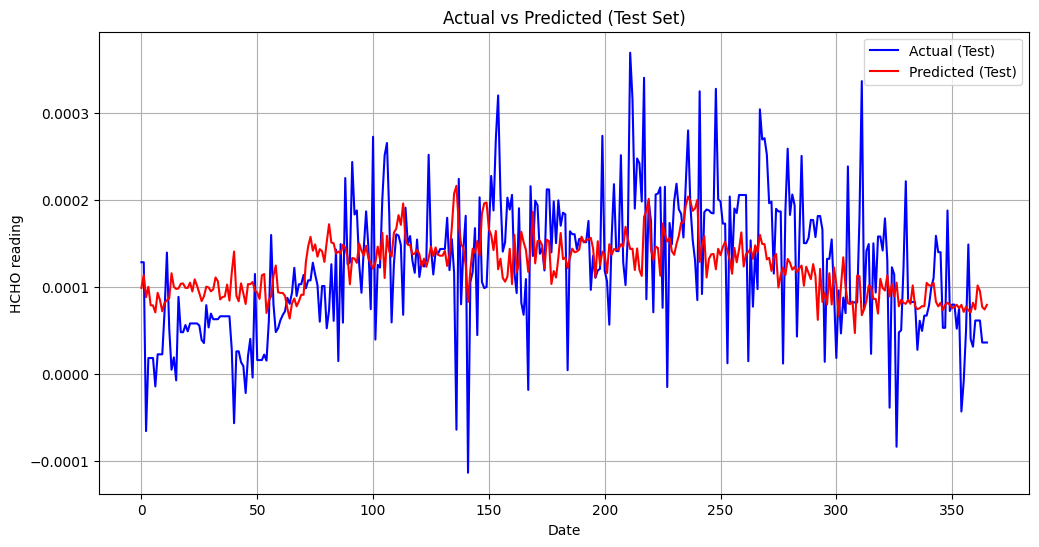

In [26]:
# Plot actual vs predicted for test set
plt.figure(figsize=(12, 6))
plt.plot([x for x in range(0, len(y_test))], y_test, label='Actual (Test)', color='blue')
plt.plot([x for x in range(0, len(y_test))], y_test_pred_actual, label='Predicted (Test)', color='red')
plt.title('Actual vs Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('HCHO reading') 
plt.legend()
plt.grid(True)
plt.show()

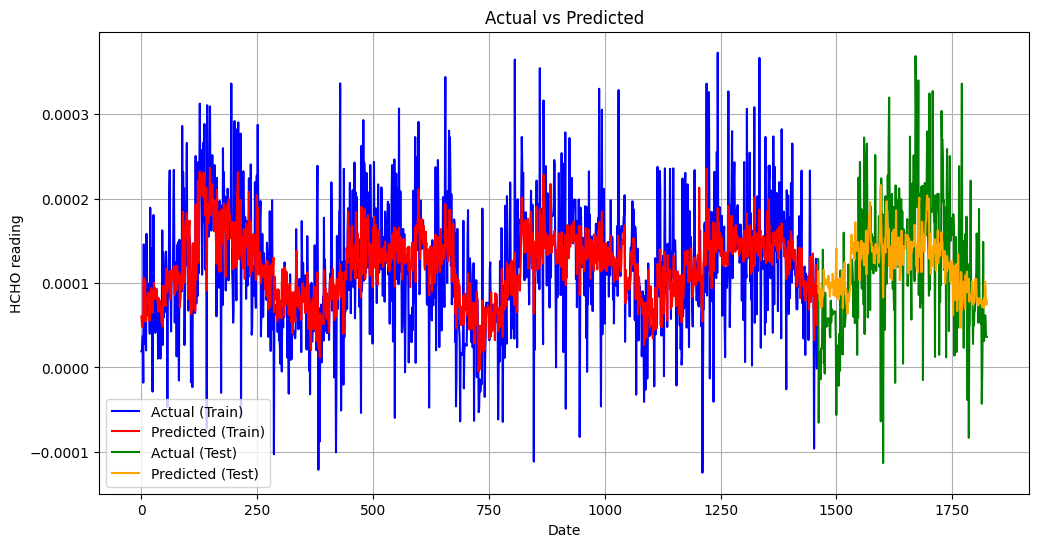

In [27]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for both training and test sets
plt.figure(figsize=(12, 6)) 
plt.plot(range(0, len(y_train)), y_train, label='Actual (Train)', color='blue')
plt.plot(range(0, len(y_train)), y_train_pred_actual, label='Predicted (Train)', color='red')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual (Test)', color='green')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test_pred_actual, label='Predicted (Test)', color='orange')
plt.title('Actual vs Predicted')
plt.xlabel('Date') 
plt.ylabel('HCHO reading')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred_actual)

# Calculate MSE
mse = mean_squared_error(y_test, y_test_pred_actual)

# Calculate R2 score 
r2 = r2_score(y_test, y_test_pred_actual)

rmse = mean_squared_error(y_test, y_test_pred_actual, squared=False)

median_absolute = median_absolute_error(y_test, y_test_pred_actual) 
 
explained_variance = explained_variance_score(y_test, y_test_pred_actual)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 5.457574435399944e-05
Mean Squared Error (MSE): 5.043650980271181e-09
R-squared (R2) Score: 0.1495630203108922
Root Mean Squared Error (RMSE): 7.101866642137954e-05
Median Absolute Error: 4.56306148612179e-05
Explained Variance Score: 0.14977170166063292


#### SARIMAX Multivariate Model

In [29]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from pmdarima import auto_arima

In [30]:
# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/monaragalaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TAVG': data["TAVG"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}

data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

In [31]:
from tqdm import tqdm
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Find the best parameters using auto_arima
# Fit the SARIMAX Model
exog_train = train[['carbon_monoxide', 'ozone', 'TAVG']]
endog_train = train['HCHO reading']

model = SARIMAX(endog_train, exog=exog_train, order=(5, 0, 0), seasonal_order=(0, 0, 0, 12))
model_fit = model.fit(disp=False)

# Forecast
yhat_sarima = []
for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = SARIMAX(temp_train, order=(5, 0, 0), seasonal_order=(0, 0, 0, 12))  
    model_fit = model.fit()
    exog_test = test[['carbon_monoxide', 'ozone', 'TAVG']].iloc[t]
    predictions = model_fit.forecast(steps=1, exog=exog_test)  
    yhat_sarima.append(predictions[-1])

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [07:17<00:00,  1.20s/it]


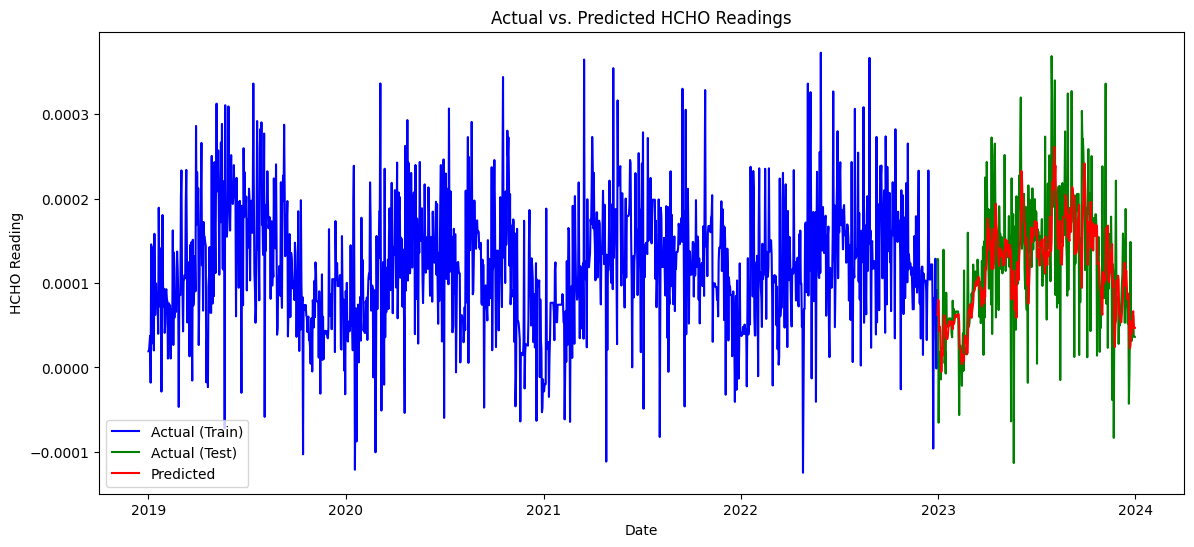

In [32]:
# Plotting
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train.index, train['HCHO reading'], label='Actual (Train)', color='blue')

# Plot testing data
plt.plot(test.index, test['HCHO reading'], label='Actual (Test)', color='green')

# Plot predicted values
plt.plot(test.index, yhat_sarima, label='Predicted', color='red')

plt.title('Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()

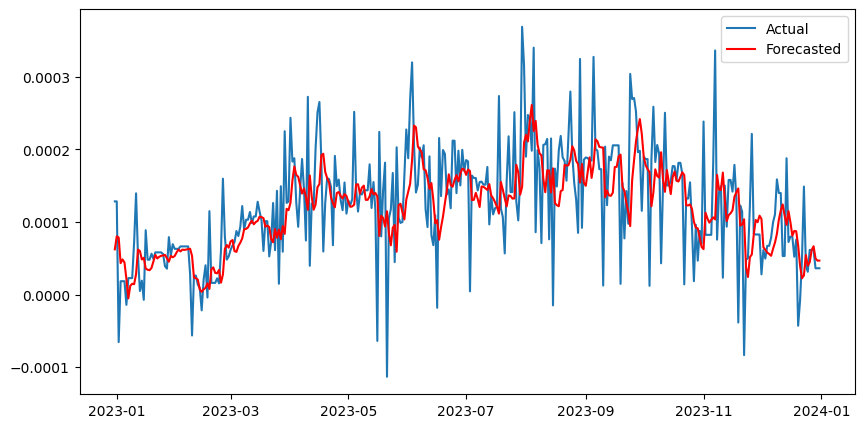

In [33]:
# Plotting the results
plt.figure(figsize=(10,5))
plt.plot(test.index, test['HCHO reading'], label='Actual')
plt.plot(test.index, yhat_sarima, label='Forecasted', color='red')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_sarima)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_sarima)

rmse = mean_squared_error(test['HCHO reading'], yhat_sarima, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_sarima)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_sarima)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.461504932419022e-05
Mean Squared Error (MSE): 4.293696889332938e-09
R-squared (R2) Score: 0.2760167924885851
Root Mean Squared Error (RMSE): 6.552630684948555e-05
Median Absolute Error: 2.606433583349303e-05
Explained Variance Score: 0.2811049096781292
